In [1]:
import matplotlib
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
    
from utils.structures import Pipeline, Deploy
from utils.data_management import dict2str
from typing import *
import tensorflow as tf
from sklearn.datasets import make_classification
import mne
from combiners import EpochsCombiner
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.machine_learning.designer import ModelDesign, ParallelDesign, LayerDesign
from utils.machine_learning.analyzer import ModelAnalyzer, LFCNNAnalyzer
from mne.datasets import multimodal
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

2022-01-29 23:36:30.910226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 23:36:30.910259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
mne.set_log_level(verbose='CRITICAL')
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
print(epochs.info)
epochs = epochs.pick_types(meg='grad')
epochs.info

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 1 EOG
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 316
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 204 Gradiometers
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>

In [3]:
X = np.array([])
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)
X = np.array([X[i, epochs._channel_type_idx['grad'], :] for i, _ in enumerate(X)])


In [7]:
clf = make_pipeline(CSP(n_components=8, reg='shrinkage', rank='full'),# good accuracy (73-78%%) and stability, but regularization sometimes bad
                    LogisticRegression())

In [8]:
scores = cross_val_multiscore(clf, X, Y, cv=5, n_jobs=1)
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

/home/user/Projects/FingerMovementDecoder/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Spatio-temporal: 34.8%


In [14]:
csp = CSP(n_components=8, reg='ledoit_wolf', norm_trace=True, rank='info')

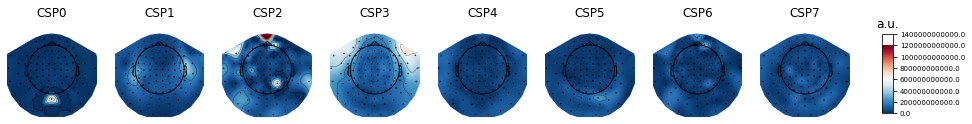

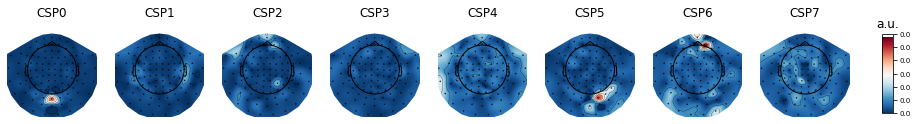

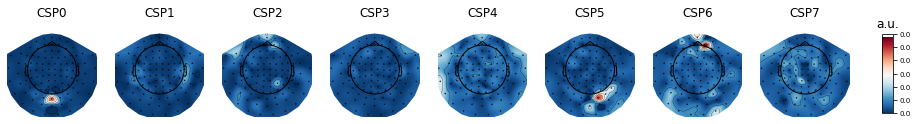

In [15]:
csp.fit(X, Y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)

In [17]:
print(csp.patterns_.shape)

(204, 204)
